# Fit to the CRPropa simulation

Fit to the data set produced in `crpropa_simulation.ipynb`.
<br>
<br>
*This code is used to produce Figure 8 (right panel) in Capel & Mortlock 2019*.

In [1]:
import h5py

from fancy import Data, Model, Analysis
from fancy.detector.auger2014 import detector_properties

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [8]:
# Define location of Stan files
stan_path = '../../stan/'

# Define files containing source catalogue information
source_file = '../../data/sourcedata.h5'
table_file = '../../data/tables_SBG_23.h5'

# Output of CRPropa simulation and full joint simulation
crpropa_sim_output = 'output/crpropa_sim.h5'
sim_output_file = '../arrival_vs_joint/output/joint_model_simulation.h5'

# Define output file
crpropa_fit_output = 'output/cpropa_fit.h5'

# Define random seed for reproducibility
random_seed = 1992071502

## Data

Read in data on source catalogue and detector parameters. UHECR data from the CRPropa simulation will be added later.


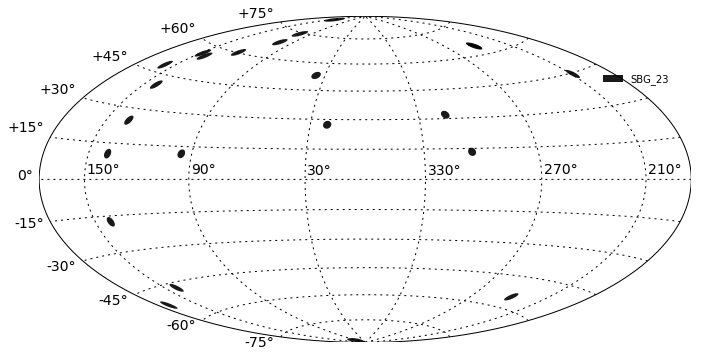

In [9]:
# Read in data on sources and detector
data = Data()
data.add_source(source_file, 'SBG_23')
data.add_detector(detector_properties)

data.show();

## Analysis

In [10]:
model_name = stan_path + 'joint_model.stan'

# Compile
model = Model(model_filename = model_name, include_paths = stan_path)
model.compile()

# Define the threshold energy in EeV
model.input(Eth = 52) 

Using cached StanModel


In [11]:
# What is happening 
summary = b'Fit of the joint model to the CRPropa simulation' 
    
# Define an Analysis object to bring together Data and Model objects
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = crpropa_fit_output, summary = summary)
analysis.use_tables(table_file)

In [12]:
# Add in CRPropa UHECR
with h5py.File(crpropa_sim_output, 'r') as f:
    uhecr = f['uhecr']
    energy = uhecr['energy'].value
    unit_vector = uhecr['unit_vector'].value
analysis.use_crpropa_data(energy, unit_vector)

Simulating zenith angles...
Done!


In [7]:
fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed)
analysis.save()
# NB: can ignore warnings for lambda, this is just a generated quantity and not a sampled parameter.

n_eff / iter looks reasonable for all parameters
Rhat for parameter lambda[133] is nan!
Rhat for parameter lambda[135] is nan!
Rhat for parameter lambda[161] is nan!
Rhat for parameter lambda[162] is nan!
Rhat for parameter lambda[177] is nan!
Rhat for parameter lambda[189] is nan!
Rhat for parameter lambda[197] is nan!
Rhat for parameter lambda[202] is nan!
Rhat for parameter lambda[204] is nan!
Rhat for parameter lambda[208] is nan!
Rhat for parameter lambda[223] is nan!
Rhat for parameter lambda[233] is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


## Figure 8 (right panel)

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame

from fancy import Results
from fancy.plotting import Corner
from fancy.plotting.colours import darkblue

# to match paper style
plt.style.use('minimalist')

In [13]:
# Get chains from joint fit and truths from simulation

results_sim = Results(sim_output_file)
results_fit = Results(crpropa_fit_output)

keys = ['alpha', 'B', 'f']
chain = results_fit.get_chain(keys)

truth_keys = ['alpha', 'B', 'f']
truth = results_sim.get_truths(truth_keys)

In [14]:
labels = {}
labels['B'] = r'$B$ / $\mathrm{nG}$'
labels['alpha'] = r'$\alpha$'
labels['f'] = r'$f$'

params = np.column_stack([chain[key] for key in keys])
truths = [truth[key] for key in keys]

# Make nicely labelled dict
chain_for_df = {}
for key in keys:
    chain_for_df[labels[key]] = chain[key]

# Make ordered dataframe
df = DataFrame(data = chain_for_df)
df = df[[labels['alpha'], labels['B'], labels['f']]]

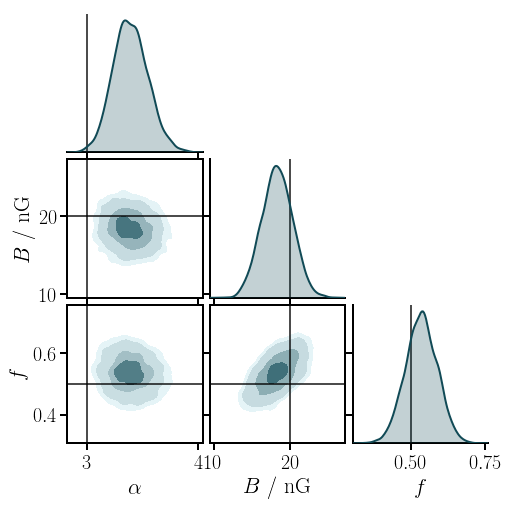

In [15]:
corner = Corner(df, truths, color = darkblue)

### Footnote

As for the left panel of Figure 8, results can be slightly different due to the use of a random seed for reproducilbility.